In [1]:
# Web path variables for the questionnaires online - to be scraped

survey_2021 = 'https://osmi.typeform.com/report/Fja7Jb9K/t5F4sKEyeGhGgU7V'

# Dataset path variables setting up
initial_2021 = r'C:\Users\Lenovo\Desktop\ML App\initial_2021.csv'

final_2021 = r'C:\Users\Lenovo\Desktop\ML App\final_2021.csv'

In [2]:
import re
import sys
import json
import requests
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
from collections import Counter

# Work on the 2021 Dataset

## 1. Survey Questions with Web Scraping

In [3]:
# Request typeform survey webpage for contents
res = requests.get(survey_2021)

# Extract response status and validate for successful transaction
status = res.status_code
if status != 200:
    sys.exit(1)
else:
    print("Web scraping response status:\n", status)

# Parse HTML title, head and body contents using BeautifulSoup
soup = BeautifulSoup(res.content, 'html.parser')

print("Dataset Title:\n", soup.title.text)

Web scraping response status:
 200
Dataset Title:
 OSMI Mental Health in Tech Survey 2021


In [4]:
# Select content inside the script element that contains information about the survey questions and answers
script = soup.select('script')[10]

# Set a Regex pattern to extract the report's payload and apply the pattern on the script text
pattern = re.compile("(?<=window.__REPORT_PAYLOAD = ).*(?=};)")
fields = re.findall(pattern, script.text)

# Complete the string to be able to input to the JSON parser
fields[0] = fields[0] + '}'

# Convert the string to JSON
json_param = json.loads(fields[0])

# Print all the questions asked in the survey
questions = json_param['blocks']
print("Number of questions in the survey:", len(questions))
print('-'*100)

# Process each question to remove * present representing bolded words
question_titles = []
for question in questions:
    question['title'] = question['title'].replace('*', '')
    question['title'] = question['title'].replace('_', '')
    question_titles.append(question['title'])
    print(question['title'])

Number of questions in the survey: 69
----------------------------------------------------------------------------------------------------
Are you self-employed?
How many employees does your company or organization have?
Is your employer primarily a tech company/organization?
Is your primary role within your company related to tech/IT?
Does your employer provide mental health benefits as part of healthcare coverage?
Do you know the options for mental health care available under your employer-provided health coverage?
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
Does your employer offer resources to learn more about mental health disorders and options for seeking help?
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
If a mental health issue prompted you to request a medical leave from work, how easy or di

In [5]:
# Analyze the types of questions asked in the survey
question_types = []
for question in questions:
    question_types.append(question['type'])
Counter(question_types)

Counter({'multiple_choice': 40,
         'yes_no': 17,
         'opinion_scale': 7,
         'dropdown': 4,
         'rating': 1})

In [6]:
# Get the total number of participants in the survey
total_resp = json_param['totalResponsesCount']

# Get the number of participants that answered each question
counts = []
for question in questions:
    # Use the get() method to retrieve the 'count' key safely
    count = question['summary'].get('count', 0)  # 0 is the default value if 'count' is not present
    counts.append(count)

print("Number of respondents for each question out of {0} participants:\n {1}".format(total_resp, counts))


Number of respondents for each question out of 131 participants:
 [131, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 113, 113, 114, 114, 17, 17, 17, 17, 17, 17, 17, 11, 131, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 83, 81, 85, 85, 131, 43, 0, 24, 36, 127, 131, 131, 131, 131, 131, 131, 131, 131, 131, 17, 7, 131, 131, 131, 131, 131, 131, 49, 49, 131, 49, 0]


## 2. Cleaning and Aggregating Columns on the Dataset from Kaggle

### Importing and Overview

In [7]:
# Import Kaggle dataset and examine the columns
data_2021 = pd.read_csv(initial_2021)

# What are the total number of columns?
print("Number of columns:", len(data_2021.columns))
print('-'*100)

# What are the columns that aren't in question format?
for count, i in enumerate(data_2021.columns):
    if '?' not in i:
        print(count, i)

Number of columns: 124
----------------------------------------------------------------------------------------------------
0 #
14 Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
17 Describe the conversation with coworkers you had about your mental health including their reactions.
19 Describe the conversation your coworker had with you about their mental health (please do not use names).
40 Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.
43 Describe the conversation you had with your previous coworkers about your mental health including their reactions.
45 Describe the conversation your coworker had with you about their mental health (please do not use names)..1
50 Anxiety Disorder (Generalized, Social, Phobia, etc)
51 Mood Di

### Analysis

From this we analyze that the dataset from OSMI has columns that aren't in the data scraped from the survey webpage. It also appears that some columns represent possible responses for questions. 

Decide to merge the corresponding columns and replace the column names with the question titles.

Since we look to aggregate columns from multiple datasets throughout the years, we merge the columns of descriptive questions to form a single column: `comments`. We also drop the first column representing the participant ID and a few other columns that are not relevant to our study.

### Name Cleaning

In [8]:
data_2021.drop(['Start Date (UTC)'], axis=1, inplace=True)

In [9]:
data_2021.drop(['Submit Date (UTC)'], axis=1, inplace=True)

In [10]:
data_2021.drop(['Network ID'], axis=1, inplace=True)

In [11]:
data_2021.drop(['#'], axis=1, inplace=True)

The columns with indices between 50 to 62, 63 to 75 and 76 to 88 correspond to, respectively,

###### What disorder(s) have you been diagnosed with?

###### If possibly, what disorder(s) do you believe you have?

###### If so, what disorder(s) were you diagnosed with?.

Therefore, we merge the corresponding columns of indices to create new columns with the attribute headings being the above qustions.

In [12]:
data_2021.rename(columns = {'Post-traumatic Stress Disorder':'Post-Traumatic Stress Disorder.1',
                           'Post-traumatic Stress Disorder.1':'Post-Traumatic Stress Disorder.2'}, inplace = True)

In [13]:
# Setup the column names that are to be merged

# Columns to be merged and replaced by `What disorder(s) have you been diagnosed with?`
cols_1 = ['Anxiety Disorder (Generalized, Social, Phobia, etc)',
          'Mood Disorder (Depression, Bipolar Disorder, etc)',
          'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)',
          'Eating Disorder (Anorexia, Bulimia, etc)',
          'Attention Deficit Hyperactivity Disorder',
          'Personality Disorder (Borderline, Antisocial, Paranoid, etc)',
          'Obsessive-Compulsive Disorder',
          'Post-Traumatic Stress Disorder',
          'Stress Response Syndromes',
          'Dissociative Disorder',
          'Substance Use Disorder',
          'Addictive Disorder',
          'Other']

# Columns to be merged and replaced by `If possibly, what disorder(s) do you believe you have?`
cols_2 = [i + '.1' for i in cols_1]

# Columns to be merged and replaced by `If so, what disorder(s) were you diagnosed with?`
cols_3 = [i + '.2' for i in cols_1]

# Columns to be merged and replaced by `comments`
cols_4 = ['Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.',
          'Describe the conversation with coworkers you had about your mental health including their reactions.',
          'Describe the conversation your coworker had with you about their mental health (please do not use names).',
          'Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.',
          'Describe the conversation you had with your previous coworkers about your mental health including their reactions.',
          'Describe the conversation your coworker had with you about their mental health (please do not use names)..1',
          'Describe the circumstances of the badly handled or unsupportive response.',
          'Describe the circumstances of the supportive or well handled response.',
          'Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.',
          'If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.',
          'Other.3']

# Names of the attributes after transformation 
q_1 = 'What disorder(s) have you been diagnosed with?'
q_2 = 'If possibly, what disorder(s) do you believe you have?'
q_3 = 'If so, what disorder(s) were you diagnosed with?'
q_4 = 'comments'

In [14]:
# Function defined to merge a list of columns to form a new column with the input name
def merge_columns(df, new_col, col_list):
    '''
    Input: 
        df - Dataframe being worked on (Pandas Dataframe)
        new_col - List of column
    
    '''
    df[new_col] = df[col_list].apply(lambda x: ', '.join(x.dropna().astype(str)), 1)
    df[new_col] = df[new_col].apply(lambda aCode: np.nan if aCode == '' else aCode)
    df.drop(col_list, axis=1, inplace=True)

In [15]:
merge_columns(data_2021, q_1, cols_1)
merge_columns(data_2021, q_2, cols_2)
merge_columns(data_2021, q_3, cols_3)
merge_columns(data_2021, q_4, cols_4)

In [16]:
print("Number of columns:", len(data_2021.columns))
for i in range(len(data_2021.columns)):
    for string in ['<strong>', '</strong>', '<em>', '</em>', '*', '_']:
        data_2021.rename(columns = {data_2021.columns[i]:data_2021.columns[i].replace(string, '')}, inplace=True)

Number of columns: 74


In [17]:
# Analyze the attributes that are present in the OSMI dataset and not in the scraped dataset
print([i for i in data_2021.columns if i not in question_titles])

['Why or why not?', 'Why or why not?.1', 'What is your age?', 'What is your gender?', 'comments']


The attributes age, gender and comments are important for the final aggregation, and so we retain them as is. We do not need the explanatory questions, and so they are dropped.

In [18]:
data_2021.drop(['Why or why not?', 'Why or why not?.1',
               'Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used anonymously and only with your permission.)'], axis=1, inplace=True)

## 3. Final Attribute-wise Cleaned OSMI Dataset

In [19]:
print(len(data_2021.columns))
print(*[i for i in data_2021.columns], sep='\n')

71
Are you self-employed?
How many employees does your company or organization have?
Is your employer primarily a tech company/organization?
Is your primary role within your company related to tech/IT?
Does your employer provide mental health benefits as part of healthcare coverage?
Do you know the options for mental health care available under your employer-provided health coverage?
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
Does your employer offer resources to learn more about mental health disorders and options for seeking help?
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?
Would you feel more comfortable talking to your coworkers about your physical health or your 

In [20]:
print("Questions on the OSMI dataset and not on the survey web page:")
print(*[(str(count) + '. ' + str(i)) for count, i in enumerate(data_2021.columns) 
        if i not in question_titles], sep='\n')
print("Questions on the survey web page and not on the OSMI dataset:")
print(*[(str(count) + '. ' + str(i)) for count, i in enumerate(question_titles) 
        if i not in data_2021.columns], sep='\n')

Questions on the OSMI dataset and not on the survey web page:
59. What is your age?
60. What is your gender?
70. comments
Questions on the survey web page and not on the OSMI dataset:
62. Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used anonymously and only with your permission.)


In [21]:
data_2021.head()

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?",...,What country do you live in?,What US state or territory do you live in?,What is your race?,What country do you work in?,What US state or territory do you work in?,Have you been diagnosed with COVID-19?,What disorder(s) have you been diagnosed with?,"If possibly, what disorder(s) do you believe you have?","If so, what disorder(s) were you diagnosed with?",comments
0,0,26-100,1.0,1.0,I don't know,No,No,I don't know,I don't know,Very easy,...,United States of America,Alaska,White,United States of America,Alaska,NaN,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,NaN
1,0,500-1000,1.0,1.0,Yes,No,Yes,Yes,Yes,I don't know,...,Brazil,NaN,NaN,Brazil,NaN,NaN,NaN,NaN,NaN,NaN
2,0,100-500,1.0,1.0,Yes,Yes,No,I don't know,I don't know,Somewhat easy,...,Brazil,NaN,NaN,Brazil,NaN,NaN,NaN,NaN,NaN,"Something about been stressed about deadlines,..."
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Italy,NaN,NaN,Italy,NaN,NaN,NaN,NaN,NaN,"lk, j"
4,0,More than 1000,0.0,1.0,Yes,No,Yes,Yes,I don't know,Difficult,...,Canada,NaN,NaN,Canada,NaN,NaN,NaN,NaN,NaN,understandable


In [22]:
data_2021 = data_2021[sorted(data_2021.columns)]
data_2021.head()
data_2021.to_csv(final_2021)

In [23]:
data_2021.head()

,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you believe your productivity is ever affected by a mental health issue?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?,comments
0,0,0,1.0,0.0,1.0,Some did,Some did,NaN,Possibly,I don't know,...,White,Yes,No,No,Maybe,Physical health,"Yes, at all of my previous employers",Some of my previous supervisors,Mental health,NaN
1,0,0,0.0,1.0,0.0,None did,Some did,NaN,No,No,...,NaN,Maybe,No,Maybe,No,Physical health,"No, at none of my previous employers","No, none of my previous supervisors",Physical health,NaN
2,0,0,0.0,0.0,0.0,None did,None did,NaN,No,No,...,NaN,Maybe,Maybe,Yes,Maybe,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Same level of comfort for each,"Something about been stressed about deadlines,..."
3,0,1,NaN,NaN,NaN,NaN,NaN,No,Don't Know,Yes,...,NaN,No,Maybe,NaN,NaN,NaN,NaN,NaN,NaN,"lk, j"
4,0,0,1.0,0.0,1.0,"Yes, they all did","Yes, they all did",NaN,No,No,...,NaN,No,No,Maybe,No,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health,understandable


# Aggregating Datasets for the Years 2017-2021

In [24]:
#Rseading the datasets
df1=pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_2017.csv')
df2=pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_2018.csv')
df3=pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_2019.csv')
df4=pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_2020.csv')
df5=pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_2021.csv')

In [25]:
print(df1.shape,df2.shape,df3.shape, df4.shape, df5.shape)

(756, 71) (417, 71) (352, 71) (180, 71) (131, 72)


In [26]:
#Adding timestamp to the dataframes since we want to include time in our analysis
df1.insert(loc=0, column='Timestamp', value='2017')
df2.insert(loc=0, column='Timestamp', value='2018')
df3.insert(loc=0, column='Timestamp', value='2019')
df4.insert(loc=0, column='Timestamp', value='2020')
df5.insert(loc=0, column='Timestamp', value='2021')

In [27]:
# Assuming df1, df2, df3, df4, and df5 are your DataFrames
dfs = [df1, df2, df3, df4, df5]

# Concatenate DataFrames
df = pd.concat(dfs, ignore_index=True, join='outer')

# Clean and standardize the 'What is your gender?' column
df['What is your gender?'] = df['What is your gender?'].str.strip().str.lower()  # Remove leading/trailing whitespace and convert to lowercase

In [28]:
df.shape

(1836, 73)

In [29]:
df = df.loc[:,~df.columns.duplicated()]

In [30]:
df.shape

(1836, 73)

In [31]:
print(df.columns)


Index(['Timestamp', 'Unnamed: 0',
       'Are you openly identified at work as a person with a mental health issue?',
       'Are you self-employed?',
       'Did you ever discuss your mental health with a previous coworker(s)?',
       'Did you ever discuss your mental health with your previous employer?',
       'Did you ever have a previous coworker discuss their or another coworker's mental health with you?',
       'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
       'Did your previous employers provide resources to learn more about mental health disorders and how to seek help?',
       'Do you believe your productivity is ever affected by a mental health issue?',
       'Do you currently have a mental health disorder?',
       'Do you have a family history of mental illness?',
       'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health dis

## Cleaning the Merged Dataset

### Dealing with Null Values

In [32]:
df.to_csv(r'C:\Users\Lenovo\Desktop\ML App\final.csv')

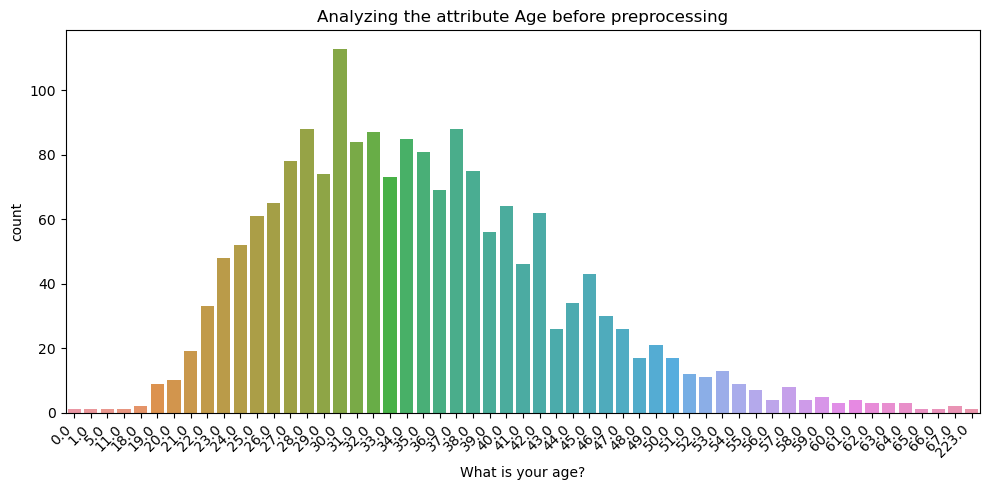

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the 'What is your age?' column to numeric, coercing non-numeric values to NaN
df['What is your age?'] = pd.to_numeric(df['What is your age?'], errors='coerce')

# Remove rows with NaN values in the 'What is your age?' column
df = df.dropna(subset=['What is your age?'])

# Set the figure size
plt.figure(figsize=(10, 5))

# Plot a countplot for age with organized X-axis labels
age = sns.countplot(data=df, x='What is your age?', order=sorted(df['What is your age?'].unique()))

# Set a title
age.set_title('Analyzing the attribute Age before preprocessing')

# Set X-axis labels and ticks from 0 to the oldest age
plt.xticks(range(len(df['What is your age?'].unique())), sorted(df['What is your age?'].unique()))

# Rotate and align X-axis labels for better readability
age.set_xticklabels(age.get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


In [34]:
# Get the unique values of ages
print("Unique values:\n", df['What is your age?'].unique())

Unique values:
 [ 27.  31.  36.  22.  52.  30.  38.  35.  40.  23.  34.  28.  53.  21.
  18.  37.  25.  33.  66.  32.  46.  29.  39.  42.  43.  47.  64.  45.
  54.  61.  26.  44.  50.  24.  57.  48.  41.  20.  49.  62.  51.  60.
  58.  59.  67.  56.  55.  19.  65.   0.  63.   5.   1.  11. 223.]


In [35]:
# How many dubious values of ages of each type do we have?
print("Responses with ages less than 18:")
print(df[df['What is your age?'] < 18]['What is your age?'])
print("\nResponses with ages more than 80:")
print(df[df['What is your age?'] > 80]['What is your age?'])
print("\nNull responses:", df['What is your age?'].isnull().sum())


Responses with ages less than 18:
1287     0.0
1530     5.0
1531     1.0
1739    11.0
Name: What is your age?, dtype: float64

Responses with ages more than 80:
1743    223.0
Name: What is your age?, dtype: float64

Null responses: 0


In [36]:
# Replace values of ages less than 18 and more than 80 with the median

# Calculate previous median
median_without_dubious = df.loc[ (df['What is your age?'] > 18) | (df['What is your age?'] < 80), 'What is your age?'].median()

# Replace dubious values with median
df.loc[ (df['What is your age?'] < 18) | (df['What is your age?'] > 80), 'What is your age?'] = median_without_dubious

# Describe the attribute to analyze min and max
df['What is your age?'].describe()

count    1834.000000
mean       34.773173
std         8.553150
min        18.000000
25%        28.000000
50%        34.000000
75%        40.000000
max        67.000000
Name: What is your age?, dtype: float64

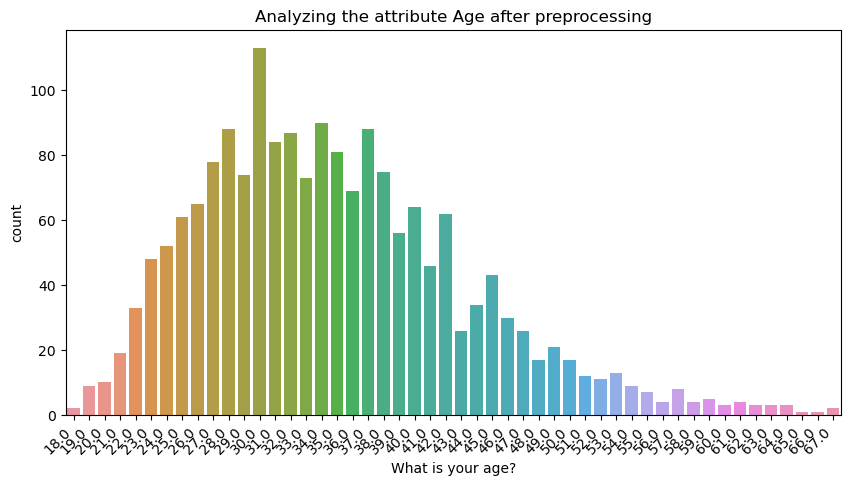

In [37]:
# Plot a histogram for the values of ages after preprocessing
plt.rcParams["figure.figsize"] = (10, 5)
age = sns.countplot(data=df, x='What is your age?')
age.set_title('Analyzing the attribute Age after preprocessing')
age.set_xticklabels(age.get_xticklabels(), rotation=40, ha="right")
plt.xticks(rotation=45)
plt.show()

**Analysis**

The graph for the continuous Age attribute is a **positively skewed histogram**. Many people fall into the age 30 and 33 bins.

In [38]:
# Get the unique values of ages
print("Unique values:\n", df['What is your age?'].unique())

Unique values:
 [27. 31. 36. 22. 52. 30. 38. 35. 40. 23. 34. 28. 53. 21. 18. 37. 25. 33.
 66. 32. 46. 29. 39. 42. 43. 47. 64. 45. 54. 61. 26. 44. 50. 24. 57. 48.
 41. 20. 49. 62. 51. 60. 58. 59. 67. 56. 55. 19. 65. 63.]


### Gender attribute

In [39]:
# Are there any null values?
df['What is your gender?'].isnull().sum()

26

In [40]:
# What are the unique values in the Gender column?
df['What is your gender?'].unique()

array(['female', 'male', 'f', 'm', 'man', nan, 'genderfluid', 'nonbinary',
       'cis-male', 'mail', 'woman', 'male/androgynous', 'cis hetero male',
       'femalw', 'femail', 'male (cis)', 'uhhhhhhhhh fem genderqueer?',
       "male (hey this is the tech industry you're talking about)",
       'female (cis)', 'god king of the valajar', 'cis male',
       'my sex is female.', 'non-binary', 'male, cis',
       'agender/genderfluid', 'male-ish', 'sometimes',
       'female (cisgender)', 'woman-identified', 'contextual',
       'non binary', 'genderqueer demigirl', 'genderqueer/non-binary',
       'cis-female', 'cis female', 'f, cisgender', 'female-ish', '\\-',
       'trans woman', 'transfeminine', 'dude', 'ostensibly male',
       'agender', 'male, born with xy chromosoms', 'malel',
       'i identify as female', '*shrug emoji* (f)',
       'male (or female, or both)', 'trans man', 'transgender',
       'female/gender non-binary.', 'cis woman', 'cisgendered woman',
       'genderqueer'

In [41]:
# Remove the records with those attribute values
df = df[~df['What is your gender?'].isin(['rr', '43'])]

In [42]:
# Replace the strings with the values of bins we require
# Group all related strings into bins




# Group into Female bin
df["What is your gender?"] = df["What is your gender?"].str.lower()
df['What is your gender?'].replace(['f','female ', 'femalw', 'femail', 'female (cis)', 'female (cis) ','cis female ',
                            'my sex is female.', 'female (cisgender)', 'woman-identified', 'cis-female', 
                            'cis female', 'f, cisgender', 'female-ish', 'trans woman', 'i identify as female',
                            '*shrug emoji* (f)', 'cis woman', 'cisgendered woman', 'trans female', 'woman',
                            'cisgender female','female, she/her','female-identified','femmina','femile'], 'female', inplace=True)

# Group into Male bin
df["What is your gender?"].replace(['m', 'man', 'cis-male', 'mail', 'male/androgynous ','cis hetero male', 
                            'male (cis)','male (hey this is the tech industry you\'re talking about)',
                            'god king of the valajar', 'cis male', 'male ', 'male, cis', 'cis male ',
                            'male-ish','dude','ostensibly male','male, born with xy chromosoms','malel', 
                            'trans man','cisgender male', 'swm',"let's keep it simple and say 'male'",'identify as male','masculino','mostly male','cishet male','i have a penis','masculine','male/androgynous','let\'s keep it simple and say "male"','make','male/he/him', 'homem cis', 'cis-het male'], "male", inplace=True)

# Group into Other bin
df["What is your gender?"].replace(['gender non-binary/other','nonbinary','non-binary','non binary','uhhhhhhhhh fem genderqueer?',
                            'agender/genderfluid','sometimes','contextual','genderqueer demigirl','genderqueer/non-binary',
                            '\\-','transfeminine','agender','male (or female, or both)','female/gender non-binary.', 
                            'genderqueer','demiguy','she/her/they/them','other','nonbinary/femme','genderfluid', 'none',
                           'transgender', 'nb', 'gender non-conforming woman','trans non-binary/genderfluid','questioning','i am a wookie','non-binary and gender fluid','rr','43','agender trans woman', 'afab non-binary', 'b', 'non-binary/agender'], 
                           "other", inplace=True)

df['What is your gender?'].describe()

count     1806
unique       3
top       male
freq      1192
Name: What is your gender?, dtype: object

In [43]:
# What are the unique values in the Gender column?
df['What is your gender?'].unique()

array(['female', 'male', nan, 'other'], dtype=object)

In [44]:
df['What is your gender?'].fillna(value="male", inplace=True)

We will fill all Nan with male since majority of people who filled the questionnaire are male

In [45]:
# Viewing the counts of each type
df['What is your gender?'].value_counts()

What is your gender?
male      1218
female     565
other       49
Name: count, dtype: int64

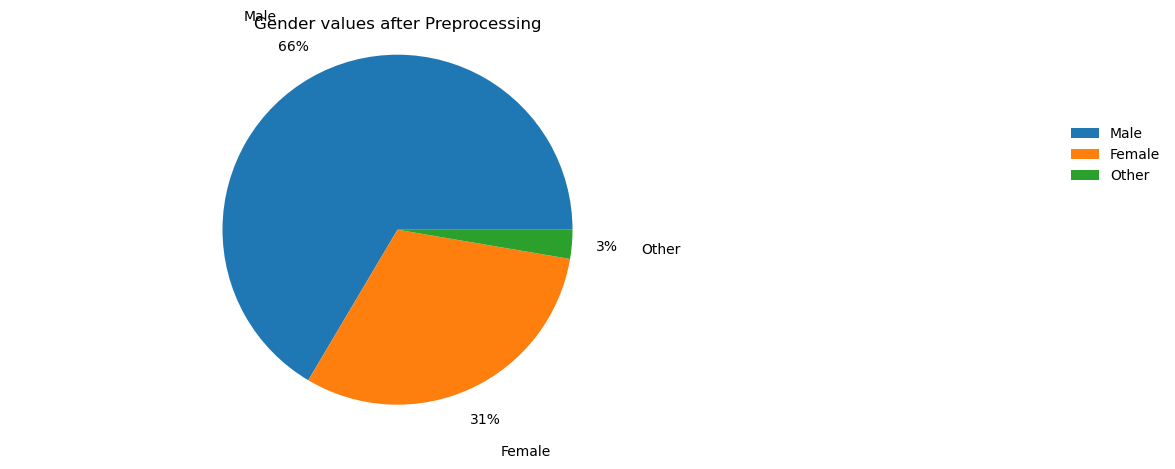

In [46]:
# Visualizing the proportion of genders
fig, ax = plt.subplots()
labels = ['Male', 
         'Female',
         'Other']
male_perc = (df['What is your gender?'] == 'male').sum() / df['What is your gender?'].count()
female_perc = (df['What is your gender?'] == 'female').sum() / df['What is your gender?'].count()
other_perc = (df['What is your gender?'] == 'other').sum() / df['What is your gender?'].count()

percentages = [male_perc, female_perc, other_perc]

ax.pie(percentages, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Gender values after Preprocessing")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

As the plot suggests, male responders far outnumber the female and other responders. This is a point to keep in mind as we work on our models in the future.

### 4. Dealing with the `comments` attribute

Viewing comments after droping rows with missing values

In [47]:
for count, i in enumerate(df['comments'].dropna()):
    if count < 30:
        print(i[:80])

Spoke about my anxiety they were very supportive, they spoke about their depress
the coworker was comprehensive, empathetic and understanding, a discussion about
The conversation went well, he too suffers mental illness... however, I was just
Direct Manager and HR know because of medication. No real reactions, Coworkers t
I'm in mental heatlh so I talk about it often., They talked about as caregivers 
Awareness, changed work schedules and expectations
I've talked about my depression with coworkers in the past. They were good liste
One of my coworkers took a month off due to burn out and we talked about it afte
Don’t know 
ok, OK, ok, ok, ok
I needed to discuss accommodations due to Autism and ADHD.  The conversation was
Several times I've seen people with depression or other mental problems be fired
Are you OK?
Yeup, What's up, guys?
I think that the opportunity to have mental health sick leave should be just as 
"I suffer from extreme anxiety and ADD, and take medication for both. Som

### 5 .Dealing with `race` attribute

In [48]:
# cleaning up racial responses
hispanics = ["Hispanic","Hispanic or Latino","Latina","Latino","Latinx","mexican american "]
no_answer = ["Did not answer","I prefer not to answer",
             "I am of the race of Adam, the first human."]
mixed = ["Mixed","More than one of the above","Hispanic, White","Mestizo"]
jewish = ["Jewish","Ashkenazi"]
caucasian = ["Caucasian","White","European American",
             "My race is white, but my ethnicity is Latin American"]
caribbean = ["Caribbean","Indo-Caribbean","West Indian"]
asian = ["Asian","South Asian"]
aa = ["Afrcian American","Black or African American"]

race_list = [hispanics,no_answer,mixed,jewish,caucasian,caribbean,asian,aa]

for race in race_list:
    for num,info in enumerate(race):
        if num > 0:
            df["What is your race?"][df["What is your race?"]==info] = race[0]
df['What is your race?'].isna().sum()

    

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22600\1422248681.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["What is your race?"][df["What is your race?"]==info] = race[0]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22600\1422248681.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["What is your race?"][df["What is your race?"]==info] = race[0]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22600\1422248681.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

732

In [49]:
print(df['What is your race?'].value_counts())
df['What is your race?'].fillna(value="Caucasian", inplace=True)

What is your race?
Caucasian                           958
Asian                                55
Mixed                                37
Did not answer                       30
Afrcian American                     17
American Indian or Alaska Native      1
Hispanic                              1
White Hispanic                        1
Name: count, dtype: int64


## Dealing with missing values of rating column

In [50]:
median = np.median(df['Overall, how well do you think the tech industry supports employees with mental health issues?'][df['Overall, how well do you think the tech industry supports employees with mental health issues?'].isna()==False])
df['Overall, how well do you think the tech industry supports employees with mental health issues?'].fillna(median,inplace=True)

### 5 .Dealing with `employee` attribute

In [51]:
print(df['How many employees does your company or organization have?'].value_counts())
df['How many employees does your company or organization have?'].isna().sum()

How many employees does your company or organization have?
More than 1000    494
100-500           409
26-100            291
6-25              210
500-1000          135
1-5                37
Name: count, dtype: int64


256

In [52]:
df['How many employees does your company or organization have?'].fillna(0,inplace=True)

We replace all the nan values by 0

In [53]:
df.drop(columns=['comments'], inplace = True)

About 70% of the `comments` column is empty hence we drop the comments section too

In [54]:
df.columns

Index(['Timestamp', 'Unnamed: 0',
       'Are you openly identified at work as a person with a mental health issue?',
       'Are you self-employed?',
       'Did you ever discuss your mental health with a previous coworker(s)?',
       'Did you ever discuss your mental health with your previous employer?',
       'Did you ever have a previous coworker discuss their or another coworker's mental health with you?',
       'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
       'Did your previous employers provide resources to learn more about mental health disorders and how to seek help?',
       'Do you believe your productivity is ever affected by a mental health issue?',
       'Do you currently have a mental health disorder?',
       'Do you have a family history of mental illness?',
       'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health dis

## Dealing with missing values

In [55]:
df.isnull().sum()

Timestamp                                                                                                                      0
Unnamed: 0                                                                                                                     0
Are you openly identified at work as a person with a mental health issue?                                                      0
Are you self-employed?                                                                                                         0
Did you ever discuss your mental health with a previous coworker(s)?                                                         298
                                                                                                                            ... 
Would you feel more comfortable talking to your coworkers about your physical health or your mental health?                  256
Would you have been willing to discuss your mental health with your coworkers at previous employe

Viewing the number the null values in each of the column matrix attribute

In [56]:
df.shape

(1832, 72)

We observe that a lot of columns  have null values and we  drop columns with over 50% NaN values

In [57]:
delete_list = df.isna().sum()[df.isna().sum() > 587]
for num in range(len(delete_list)):
    df.drop(columns = delete_list.index[num],inplace=True)

We observe that about 16 columns had more than 50% null values hence they were dropped

In [58]:
df.shape

(1832, 55)

### 6. Removing the unwanted index columns

In [59]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [60]:
df.head()

,Timestamp,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,2017,0.0,0,0.0,0.0,0.0,Some did,Some did,Possibly,No,...,female,Caucasian,Yes,No,Yes,Yes,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,2017,0.0,0,1.0,0.0,0.0,None did,None did,Possibly,No,...,male,Caucasian,Yes,No,Yes,Maybe,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,2017,1.0,0,1.0,0.0,0.0,None did,None did,Yes,Yes,...,male,Caucasian,Maybe,No,Maybe,Yes,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,2017,0.0,0,NaN,NaN,NaN,NaN,NaN,Yes,I don't know,...,male,Caucasian,No,No,Yes,Yes,Same level of comfort for each,NaN,NaN,NaN
4,2017,0.0,1,1.0,0.0,1.0,None did,None did,No,Yes,...,female,Mixed,Maybe,No,NaN,NaN,NaN,"No, at none of my previous employers","No, none of my previous supervisors",Same level of comfort for each


In [61]:
len(df.columns)

54

### 7. Column names

Since the column names are very long, in order to analyze them, we create a CSV file with the column names

In [62]:
col_df=pd.DataFrame(columns=['ColumnNumber','ColumnName'])
col_df['ColumnNumber']=[i for i in range(0,df.shape[1])]
col_df['ColumnName']=df.columns
col_df.shape

(54, 2)

In [63]:
col_df.to_csv(r'C:\Users\Lenovo\Desktop\ML App\columns.csv')

### 8. Dropping Rows which have more than 25% null values

In [64]:
df.shape

(1832, 54)

In [65]:
len(df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > (df.shape[1]/4)])

512

In [66]:
delete_rows = df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > (df.shape[1]/4)]
for num in range(len(delete_rows)):
    df.drop(delete_rows.index[num],axis=0,inplace=True)

In [67]:
df.shape

(1320, 54)

### 9.Dealing with the remaining NULL values

#### Checking which columns have null

In [68]:
cnt=0
for i in df.columns:
    print(cnt,df[i].isnull().sum())
    cnt+=1

0 0
1 0
2 0
3 6
4 0
5 9
6 0
7 0
8 0
9 0
10 0
11 134
12 0
13 0
14 0
15 4
16 0
17 5
18 0
19 13
20 0
21 0
22 251
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0


#### Finding the mode of each columns with nulls

In [69]:
for i in df.columns:
    if df[i].isnull().sum()>0:
        print(df.columns.get_loc(i),df[i].mode()[0])

3 0.0
5 0.0
11 No
15 0.0
17 0.0
19 Yes
22 No


#### Column-wise strategy for replacing NULLS:

3	Did you ever discuss your mental health with a previous coworker(s)?
- Replace with mode

5	Did you ever have a previous coworker discuss their or another coworker's mental health with you?
- Replace with mode

11	Do you know the options for mental health care available under your employer-provided health coverage?
- Replace with mode

15	Have you ever discussed your mental health with coworkers?
- Replace with mode

17	Have you ever had a coworker discuss their or another coworker's mental health with you?
- Replace with mode

19	Have you had a mental health disorder in the past?
- Replace with "Don't Know"

22	Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?
- Replace with "No Answer" (Since there are 251 nulls)

In [70]:
mode_int_cols=[3,5,15,17]

for i in mode_int_cols:
    df[df.columns[i]].fillna(int(float((df[df.columns[i]].mode()[0]))), inplace=True)
df[df.columns[11]].fillna(df[df.columns[6]].mode()[0], inplace=True)
df[df.columns[19]].fillna("Don't Know", inplace=True)
df[df.columns[22]].fillna("No_Answer", inplace=True)

In [71]:
df.isnull().values.any()

False

### There are no more null values in the dataset, it is ready to go to the next stage of preprocessing

In [72]:
df.to_csv(r'C:\Users\Lenovo\Desktop\ML App\final.csv',index=False)

# PART 4

In [73]:
df = pd.read_csv(r'C:\Users\Lenovo\Desktop\ML App\final_pre.csv')
df.shape

(1320, 54)

## Analysing the features

In [74]:
df.head()

,Timestamp,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,2017,0,0,0,0,0,Some did,Some did,Possibly,No,...,female,Caucasian,Yes,No,Yes,Yes,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,2017,0,0,1,0,0,None did,None did,Possibly,No,...,male,Caucasian,Yes,No,Yes,Maybe,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,2017,1,0,1,0,0,None did,None did,Yes,Yes,...,male,Caucasian,Maybe,No,Maybe,Yes,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,2017,0,0,0,0,0,None did,Some did,No,Yes,...,male,Caucasian,Maybe,No,Maybe,Maybe,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health
4,2017,1,0,1,1,1,None did,None did,Yes,Yes,...,female,Asian,No,No,No,Yes,Same level of comfort for each,At some of my previous employers,Some of my previous supervisors,Same level of comfort for each


In [75]:
df.isnull().values.any()

False

In [76]:
cnt=0
for i in df.columns:
    print(cnt, df[i].dtype)
    cnt+=1

0 int64
1 int64
2 int64
3 object
4 object
5 object
6 object
7 object
8 object
9 object
10 int64
11 object
12 object
13 object
14 object
15 object
16 object
17 object
18 int64
19 object
20 object
21 object
22 object
23 object
24 object
25 int64
26 object
27 int64
28 object
29 object
30 object
31 object
32 object
33 int64
34 int64
35 int64
36 int64
37 int64
38 object
39 object
40 object
41 object
42 object
43 int64
44 object
45 object
46 object
47 object
48 object
49 object
50 object
51 object
52 object
53 object


In [77]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,Do you know the options for mental health care available under your employer-provided health coverage?,Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Does your employer provide mental health benefits as part of healthcare coverage?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,0,0,0,Some did,Some did,Possibly,No,Yes,I don't know,No,...,female,Caucasian,Yes,No,Yes,Yes,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,1,0,0,None did,None did,Possibly,No,Yes,No,Yes,...,male,Caucasian,Yes,No,Yes,Maybe,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,1,0,0,None did,None did,Yes,Yes,No,No,I don't know,...,male,Caucasian,Maybe,No,Maybe,Yes,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,0,0,0,None did,Some did,No,Yes,No,I don't know,Yes,...,male,Caucasian,Maybe,No,Maybe,Maybe,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health
4,1,1,1,None did,None did,Yes,Yes,Yes,No,Yes,...,female,Asian,No,No,No,Yes,Same level of comfort for each,At some of my previous employers,Some of my previous supervisors,Same level of comfort for each


In [78]:
obj_df.shape

(1320, 41)

In [79]:
obj_df.rename(columns={obj_df.columns[i]:df.columns.get_loc(obj_df.columns[i]) for i in range(obj_df.shape[1])}, inplace=True)

## 1. Columns which have numeric values

These columns can be directly converted to numeric columns

In [80]:
numer_cols=[3,4,5,15,16,17,31,32,39]

In [81]:
df.loc[df[df.columns[0]] == 2021].groupby([df.columns[3]]).size()

Did you ever discuss your mental health with a previous coworker(s)?
0    44
1    30
dtype: int64

In [82]:
cleanup_nums={df.columns[i]:{"True":1, "False":0} for i in numer_cols}

In [83]:
df = df.replace(cleanup_nums)

In [84]:
numer_cols = [3, 4, 5, 15, 16, 17, 31, 32, 39]

for i in numer_cols:
    # Use pd.to_numeric with errors='coerce' to convert to numeric, converting non-numeric values to NaN
    df[df.columns[i]] = pd.to_numeric(df[df.columns[i]], errors='coerce')
    
    # Fill NaN values with a specific value, e.g., -1 (you can choose an appropriate value)
    df[df.columns[i]].fillna(-1, inplace=True)
    
    # Convert the column to integer data type
    df[df.columns[i]] = df[df.columns[i]].astype('int')


Now the conversion of columns which were already numerical is done successfully

## 2. Columns which have categorical values

Here, we are going to replace the columns which have the following values
- No (replaced with 0)
- Yes (replaced with 1)
- I don't know (replaced with 2)
- Maybe (replaced with 2)


In [85]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,Do you know the options for mental health care available under your employer-provided health coverage?,Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Have you had a mental health disorder in the past?,Have you observed or experienced a supportive or well handled response to a mental health issue in your current or previous workplace?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,Some did,Some did,Possibly,No,Yes,I don't know,No,No,Possibly,"Yes, I experienced",...,female,Caucasian,Yes,No,Yes,Yes,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,None did,None did,Possibly,No,Yes,No,Yes,No,Possibly,Maybe/Not sure,...,male,Caucasian,Yes,No,Yes,Maybe,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,None did,None did,Yes,Yes,No,No,I don't know,I don't know,Yes,"Yes, I experienced",...,male,Caucasian,Maybe,No,Maybe,Yes,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,None did,Some did,No,Yes,No,I don't know,Yes,No,No,"Yes, I observed",...,male,Caucasian,Maybe,No,Maybe,Maybe,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health
4,None did,None did,Yes,Yes,Yes,No,Yes,No,No,"Yes, I observed",...,female,Asian,No,No,No,Yes,Same level of comfort for each,At some of my previous employers,Some of my previous supervisors,Same level of comfort for each


In [86]:
obj_df.shape

(1320, 32)

In [87]:
yes_no_cols=[]
for i in obj_df.columns:
    if "Yes" in df[i].unique():
        print(df.columns.get_loc(i),df[i].unique())
        yes_no_cols.append(df.columns.get_loc(i))
print('\n',yes_no_cols)

8 ['Possibly' 'Yes' 'No' "Don't Know"]
9 ['No' 'Yes' "I don't know"]
11 ['Yes' 'No' 'None did']
12 ["I don't know" 'No' 'Yes']
13 ['No' 'Yes' "I don't know" 'Not eligible for coverage / NA']
14 ['No' "I don't know" 'Yes']
19 ['Possibly' 'Yes' 'No' "Don't Know"]
22 ['No' 'Yes' 'Maybe' 'No_Answer']
30 ["I don't know" 'Yes' 'No']
46 ['Yes' 'Maybe' 'No']
47 ['No' 'Yes' 'Maybe']
48 ['Yes' 'Maybe' 'No']
49 ['Yes' 'Maybe' 'No']

 [8, 9, 11, 12, 13, 14, 19, 22, 30, 46, 47, 48, 49]


In [88]:
replace_dict={"No": 0, 'Yes':1, "I don't know":2, "Don't Know":2,"Maybe":2, "Not eligible for coverage / NA":3,'Possibly':3,'No_Answer':3 }

In [89]:
cleanup_nums={df.columns[i]:replace_dict for i in yes_no_cols}

In [90]:
df = df.replace(cleanup_nums)

In [91]:
df.head()

,Timestamp,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,2017,0,0,0,0,0,Some did,Some did,3,0,...,female,Caucasian,1,0,1,1,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,2017,0,0,1,0,0,None did,None did,3,0,...,male,Caucasian,1,0,1,2,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,2017,1,0,1,0,0,None did,None did,1,1,...,male,Caucasian,2,0,2,1,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,2017,0,0,0,0,0,None did,Some did,0,1,...,male,Caucasian,2,0,2,2,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health
4,2017,1,0,1,1,1,None did,None did,1,1,...,female,Asian,0,0,0,1,Same level of comfort for each,At some of my previous employers,Some of my previous supervisors,Same level of comfort for each


## 3. Other Columns

In [92]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you know the options for mental health care available under your employer-provided health coverage?,Have you observed or experienced a supportive or well handled response to a mental health issue in your current or previous workplace?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your previous employers provided mental health benefits?,How many employees does your company or organization have?,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?","If you have a mental health disorder, how often do you feel that it interferes with your work when NOT being treated effectively (i.e., when you are experiencing symptoms)?","If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?",Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Were you aware of the options for mental health care provided by your previous employers?,What country do you live in?,What country do you work in?,What is your gender?,What is your race?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,Some did,Some did,1,"Yes, I experienced","Yes, I experienced",I don't know,100-500,I don't know,Sometimes,Sometimes,"Yes, always",N/A (was not aware),United Kingdom,United Kingdom,female,Caucasian,Same level of comfort for each,"No, at none of my previous employers","Yes, all of my previous supervisors",Physical health
1,None did,None did,1,Maybe/Not sure,"Yes, I observed",Some did,100-500,I don't know,Sometimes,Not applicable to me,I don't know,I was aware of some,United Kingdom,United Kingdom,male,Caucasian,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
2,None did,None did,0,"Yes, I experienced","Yes, I experienced",Some did,Jun-25,Difficult,Sometimes,Sometimes,I don't know,N/A (was not aware),United States of America,United States of America,male,Caucasian,Same level of comfort for each,At some of my previous employers,"No, none of my previous supervisors",Physical health
3,None did,Some did,0,"Yes, I observed","Yes, I observed","No, none did",100-500,Somewhat easy,Not applicable to me,Rarely,"Yes, always",I was aware of some,United States of America,United States of America,male,Caucasian,Physical health,At some of my previous employers,Some of my previous supervisors,Physical health
4,None did,None did,1,"Yes, I observed",No,Some did,Jun-25,Very easy,Often,Rarely,"Yes, always",I was aware of some,United States of America,United States of America,female,Asian,Same level of comfort for each,At some of my previous employers,Some of my previous supervisors,Same level of comfort for each


In [93]:
obj_df.shape

(1320, 20)

In [94]:
for i in obj_df.columns:
    print(df.columns.get_loc(i),df[i].unique())

6 ['Some did' 'None did' "I don't know" 'Yes, they all did']
7 ['Some did' 'None did' 'Yes, they all did']
11 [1 0 'None did']
20 ['Yes, I experienced' 'Maybe/Not sure' 'Yes, I observed' 'No']
21 ['Yes, I experienced' 'Yes, I observed' 'No' 'Maybe/Not sure']
23 ["I don't know" 'Some did' 'No, none did' 'Yes, they all did']
24 ['100-500' 'Jun-25' '26-100' 'More than 1000' '500-1000' '01-May']
26 ["I don't know" 'Difficult' 'Somewhat easy' 'Very easy'
 'Neither easy nor difficult' 'Somewhat difficult']
28 ['Sometimes' 'Not applicable to me' 'Often' 'Rarely' 'Never']
29 ['Sometimes' 'Not applicable to me' 'Rarely' 'Often' 'Never']
38 ['Yes, always' "I don't know" 'Sometimes' 'No']
40 ['N/A (was not aware)' 'I was aware of some' 'N/A (none offered)'
 'Yes, I was aware of all of them' 'No, I only became aware later']
41 ['United Kingdom' 'United States of America' 'Switzerland' 'Bangladesh'
 'Germany' 'Canada' 'Israel' 'Iceland' 'Japan' 'Indonesia' 'India'
 'Portugal' 'Czech Republic' 'Finl

### Dealing with `How many employees does your company or organization have?` attribute

Here, each range will be replaced by a category since most of the attributes in this dataset are ordinal

In [95]:
print(df[df.columns[24]].unique())

['100-500' 'Jun-25' '26-100' 'More than 1000' '500-1000' '01-May']


In [96]:
replace_dict={'1-5':1, '6-25':2, '26-100':3, '100-500':4, '500-1000':5, 'More than 1000':6 }

In [97]:
df = df.replace({df.columns[24]:replace_dict})

In [98]:
print(df[df.columns[24]].unique())

[4 'Jun-25' 3 6 5 '01-May']


### Other columns

The rest of the columns will be encoded using **Label Encoding**

In [99]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.shape

(1320, 20)

In [100]:
for i in obj_df.columns:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes

In [101]:
df.head()

,Timestamp,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,2017,0,0,0,0,0,2,1,3,0,...,0,3,1,0,1,1,2,1,3,1
1,2017,0,0,1,0,0,1,0,3,0,...,1,3,1,0,1,2,2,0,1,1
2,2017,1,0,1,0,0,1,0,1,1,...,1,3,2,0,2,1,2,0,1,1
3,2017,0,0,0,0,0,1,1,0,1,...,1,3,2,0,2,2,1,0,2,1
4,2017,1,0,1,1,1,1,0,1,1,...,0,2,0,0,0,1,2,0,2,2


In [102]:
cnt=0
for i in df.columns:
    if df[i].dtype=='object':
        print("YES")

### Dealing with `Timestamp`

In [103]:
replace_dict={i:i-2016 for i in df['Timestamp'].unique()}

In [104]:
df = df.replace({df.columns[0]:replace_dict})

In [105]:
df.head()

,Timestamp,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,...,What is your gender?,What is your race?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up your mental health with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?,Would you have been willing to discuss your mental health with your coworkers at previous employers?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?
0,1,0,0,0,0,0,2,1,3,0,...,0,3,1,0,1,1,2,1,3,1
1,1,0,0,1,0,0,1,0,3,0,...,1,3,1,0,1,2,2,0,1,1
2,1,1,0,1,0,0,1,0,1,1,...,1,3,2,0,2,1,2,0,1,1
3,1,0,0,0,0,0,1,1,0,1,...,1,3,2,0,2,2,1,0,2,1
4,1,1,0,1,1,1,1,0,1,1,...,0,2,0,0,0,1,2,0,2,2


### Dealing with `Is your employer primarily a tech company/organization?`

Since this survey is focused on the Tech Workplace, we will remove rows where the employer is not in Tech.

In [106]:
delete_rows = df[df['Is your employer primarily a tech company/organization?']==0]
for num in range(len(delete_rows)):
    df.drop(delete_rows.index[num],axis=0,inplace=True)

In [107]:
df.shape

(1038, 54)

#### We have successfully encoded the entire dataset

In [108]:
df.to_csv(r'C:\Users\Lenovo\Desktop\ML App\final.csv')

### Now this dataset will be used to create the model